<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# **Procesamiento de Lenguaje Natural**
# **Desafío 4: QA Bot**

> **Carrera de Especialización en Inteligencia Artificial, Facultad de Ingeniería**
>
> **Universidad de Buenos Aires, Agosto de 2024**
>
> Edgar David Guarin Castro (davidg@marketpsychdata.com)

En el presente trabajo se utilizan los datos disponibles del *Second Conversational Intelligence Challenge* [ConvAI2](https://research.facebook.com/publications/the-second-conversational-intelligence-challenge-convai2/) de conversaciones en inglés, con el objetivo de construir un BOT que respondas ciertas preguntas hechas por el usuario (QA).

## **0. Importando librerías**

In [22]:
import gdown, json, logging, os, pickle, re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from io import StringIO
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences, plot_model, to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten, LSTM, SimpleRNN
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split

## **1. Cargando los datos**

Inicialmente se verifica si el archivo `data_volunteers.json` ya existe en el sistema usando `os.access`. Si el archivo no existe, se descarga desde Google Drive usando la librería `gdown`.

Luego, el archivo se guarda con el nombre `data_volunteers.json`. El contenido del archivo se convierte en un diccionario de Python, que permite acceder a la información estructurada contenida en el archivo.

Despues se imprimen las llaves del primer elemento del diccionario `data` para mostrar los campos o atributos disponibles en cada entrada del dataset.

In [8]:
#-----------------
# Cargando el dataset
#-----------------
if os.access('data_volunteers.json', os.F_OK) is False:
    url    = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

#-----------------
# Abriendo el archivo
#-----------------
text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

#-----------------
# Mostrando los campos disponibles en cada linea del dataset
#-----------------
data[0].keys()

Downloading...
From: https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download
To: /content/data_volunteers.json
100%|██████████| 2.58M/2.58M [00:00<00:00, 157MB/s]


dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

Despues de cargar el dataset de conversaciones, su contenido se limpia y se filtran las oraciones de entrada y salida. Estas oraciones se preparan para ser utilizadas en el entrenamiento de un modelo de secuencia a secuencia (como un modelo de traducción de máquina) donde las oraciones de entrada son las "preguntas" y las de salida son las "respuestas".

In [9]:
#-----------------
# Listas de preguntas y respuestas
#-----------------
chat_in  = []
chat_out = []

#-----------------
# Listas para las oraciones de entrada, salida y salida con un token de inicio
#-----------------
input_sentences  = []
output_sentences = []
output_sentences_inputs = []

#-----------------
# Longitud máxima de oraciones
#-----------------
max_len = 30

#-----------------
# Función para formatear el texto de las oraciones
#-----------------
def clean_text(txt):
    txt = txt.lower()
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)

    return txt

#-----------------
# Procesando el dataset
#-----------------
for line in data:
    for i in range(len(line['dialog'])-1):
        #-----------------
        # Limpieza de los textos de preguntas y respuestas
        #-----------------
        chat_in  = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        #-----------------
        # Filtrado por longitud
        #-----------------
        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out

        #-----------------
        # output sentence (decoder_output) tiene <eos>
        #-----------------
        output_sentence = output + ' <eos>'

        #-----------------
        # output sentence input (decoder_input) tiene <sos>
        #-----------------
        output_sentence_input = '<sos> ' + output

        #-----------------
        # Almacenando oraciones
        #-----------------
        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

#-----------------
# Verificando las dimensiones y el contenido
#-----------------
print("Cantidad de filas utilizadas:", len(input_sentences))
print("\nEjemplos de oraciones:")
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

Cantidad de filas utilizadas: 6033

Ejemplos de oraciones:


('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

## **2. Preprocesamiento**

Con base en lo anterior, se lleva a cabo a continuación el preprocesamiento necesario para obtener las variables:

- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

Para ello se hace lo siguiente:

In [10]:
#-----------------
# Definición del tamaño máximo del vocabulario
#-----------------
MAX_VOCAB_SIZE = 8000

#-----------------
# Tokenización y construcción del vocabulario de las entradas
#-----------------
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_inputs.fit_on_texts(input_sentences)
input_sequences = tokenizer_inputs.texts_to_sequences(input_sentences)
word2idx_inputs = tokenizer_inputs.word_index
max_input_len   = max(len(seq) for seq in input_sequences)

#-----------------
# Tokenización y construcción del vocabulario de las salidas
#-----------------
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer_outputs.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_sequences = tokenizer_outputs.texts_to_sequences(output_sentences)
output_sequences_inputs = tokenizer_outputs.texts_to_sequences(output_sentences_inputs)
word2idx_outputs = tokenizer_outputs.word_index
max_out_len = max(len(seq) for seq in output_sequences)
num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) # +1 para el índice 0

#-----------------
# Padding de las secuencias para que todas tengan la misma longitud
#-----------------
encoder_input_sequences  = pad_sequences(input_sequences, maxlen=max_input_len)
decoder_input_sequences  = pad_sequences(output_sequences_inputs, maxlen=max_out_len, padding='post')

decoder_input_sequences = np.clip(decoder_input_sequences, 0, num_words_output - 1)

decoder_output_sequences = pad_sequences(output_sequences, maxlen=max_out_len, padding='post')

#-----------------
# one-hot encoder para las etiquetas
#-----------------
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)

#-----------------
# Verificando las dimensiones y el contenido
#-----------------
print(f"Numero de palabras en el vocabulario de entradas: {len(word2idx_inputs)}")
print(f"Maxima longitud de las oraciones de entrada: {max_input_len}")
print(f"Numero de palabras en el vocabulario de salidas: {len(word2idx_outputs)}")
print(f"Maxima longitud de las oraciones de salida: {max_out_len}")
print(f"Numero total de palabras de salidas (con la predicción): {num_words_output}")
print(f"Tamaño del encoder_input_sequences: {encoder_input_sequences.shape}")
print(f"Tamaño del decoder_input_sequences: {decoder_input_sequences.shape}")
print(f"Tamaño del decoder_output_sequences: {decoder_output_sequences.shape}")
print(f"Tamaño del decoder_targets shape: {decoder_targets.shape}")

Numero de palabras en el vocabulario de entradas: 1799
Maxima longitud de las oraciones de entrada: 9
Numero de palabras en el vocabulario de salidas: 1806
Maxima longitud de las oraciones de salida: 10
Numero total de palabras de salidas (con la predicción): 1807
Tamaño del encoder_input_sequences: (6033, 9)
Tamaño del decoder_input_sequences: (6033, 10)
Tamaño del decoder_output_sequences: (6033, 10)
Tamaño del decoder_targets shape: (6033, 10, 1807)


## **3. Preparando los embeddings**

Usando el preprocesamiento anterior, se usan los embeddings de Glove para transformar los tokens de entrada en vectores. De esta forma, los tokens de entrada se convierten en vectores de embeddings preentrenados, lo que mejora la capacidad del modelo para entender relaciones semánticas entre palabras que ya están aprendidas en GloVe.

Para ello, se cargan los embeddings preentrenados:

In [11]:
#-----------------
# Descargando los embeddings de GloVe
#-----------------
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

#-----------------
# Cargando los embeddings desde el archivo .pkl
#-----------------
with open('gloveembedding.pkl', 'rb') as f:
    embeddings_index = pickle.load(f)

print(f"\nSe han cargado {len(embeddings_index)} vectores de embeddings.")

Downloading...
From (original): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download
From (redirected): https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t&uuid=a352bbd3-aa5d-4290-8a50-e9837d64a99b
To: /content/gloveembedding.pkl
100%|██████████| 525M/525M [00:13<00:00, 38.9MB/s]



Se han cargado 1193514 vectores de embeddings.


Con el fin de manejar embeddings específicos de GloVe o FastText, se hace uso de la clase `WordsEmbeddings` definida a continuación y de sus subclases `GloveEmbeddings` y `FasttextEmbeddings` para cargar y procesar cada tipo de embedding:

In [12]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        #-----------------
        # Cargando los embeddings
        #-----------------
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings

        #-----------------
        # Construyendo el vocabulario
        #-----------------
        index = np.arange(self.embeddings.shape[0])

        #-----------------
        # Dicctionarios para traducir de embedding a IDX de la palabra
        #-----------------
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    #-----------------
    # Transformando palabras a indices para obtener sus embeddings
    #-----------------
    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    #-----------------
    # Convirtiendo palabras a índices
    #-----------------
    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    #-----------------
    # Convirtiendo índices a palabras
    #-----------------
    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    #-----------------
    # Cargando los embeddings desde un archivo pickle
    #-----------------
    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes  = 2**28 - 1 # 256MB
        bytes_in   = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    #-----------------
    # Convirtiendo un archivo de embeddings a pickle
    #-----------------
    def convert_model_to_pickle(self):
        # Creando un arreglo estructurado de NumPy:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)

        #-----------------
        # Cargando el arreglo numpy desde el disco usando un generador
        #-----------------
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)

        #-----------------
        # Adicionando un embedding nulo
        #-----------------
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])

        #-----------------
        # Volcando el arreglo numpy al disco usando pickle
        #-----------------
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH   = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH   = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

Ahora se crea la matriz de embeddings `embedding_matrix` que se inicializa con ceros y luego se llena con los vectores correspondientes para cada palabra en el vocabulario `word2idx_inputs`. Si una palabra no está en los embeddings preentrenados, su fila en la matriz queda como ceros:

In [13]:
#-----------------
# Lista para guardar palabras no encontradas
#-----------------
words_not_found = []

#-----------------
# Definiendo el tamaño del vocabulario y la dimensión de los embeddings
#-----------------
glove_embeddings = GloveEmbeddings()
embedding_dim    = glove_embeddings.N_FEATURES
num_words_input  = min(MAX_VOCAB_SIZE, len(word2idx_inputs))

#-----------------
# Creando la matriz de embeddings con ceros inicialmente
#-----------------
embedding_matrix = np.zeros((num_words_input, embedding_dim))

#-----------------
# Llenando la matriz de embeddings
#-----------------
for word, idx in word2idx_inputs.items():
    if idx >= num_words_input:
        continue
    embedding_vector = glove_embeddings.get_words_embeddings(word)[0]
    if embedding_vector is not None and len(embedding_vector) > 0:
        #-----------------
        # Si se encuentra el vector en el diccionario, se asigna a la matriz
        #-----------------
        embedding_matrix[idx] = embedding_vector
    #-----------------
    # Si no se encuentra, la fila permanece como ceros
    #-----------------
    else:
        words_not_found.append(word)

#-----------------
# Verificando las dimensiones y el contenido
#-----------------
print(f"Numero de palabras nulas en los embeddings: {np.sum(np.sum(embedding_matrix**2, axis=1) == 0)}")
print(f"\nDimension de los embeddings: {embedding_matrix.shape}")

Numero de palabras nulas en los embeddings: 38

Dimension de los embeddings: (1799, 50)


## **4. Entrenamiento del modelo**

A partir de la información generada anteriormente, se entrena en las siguientes celdas un modelo basado en el esquema encoder-decoder.

Se define inicialmente un modelo de secuencia a secuencia (seq2seq) utilizando una arquitectura basada en LSTM para transformar una secuencia de entrada en una secuencia de salida. El codificador convierte la secuencia de entrada en un vector de estado, que luego se usa para inicializar el decodificador. El decodificador genera la secuencia de salida paso a paso, utilizando los estados del codificador como punto de partida:

In [27]:
#-----------------
# Numero de unidades en las capas LSTM
#-----------------
n_units = 128

#-----------------
# Entrada del codificador
#-----------------
encoder_inputs = Input(shape=(max_input_len,))

#-----------------
# Capa de embedding para las entradas del codificador
#-----------------
encoder_embedding_layer = Embedding(
          input_dim     = num_words_input,
          output_dim    = embedding_dim,
          input_length  = max_input_len,
          weights       = [embedding_matrix],
          trainable     = False) # Embeddings no entrenables

#-----------------
# Representación embebida de las secuencias de entrada para el codificador
#-----------------
encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

#-----------------
# Codificador con capa LSTM que devuelve su estado interno (hidden state state_h y cell state state_c)
#-----------------
encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

#-----------------
# Entrada del decodificador
#-----------------
decoder_inputs = Input(shape=(max_out_len,))

#-----------------
# Capa de embedding para las entradas del decodificador
#-----------------
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)

#-----------------
# Representación embebida de las secuencias de entrada para el decodificador
#-----------------
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

#-----------------
# Decodificador con capa LSTM que devuelve la secuencia completa y el estado final
#-----------------
decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True, dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

#-----------------
# Capa densa de salida
#-----------------
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#-----------------
# Construcción del modelo
#-----------------
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

#-----------------
# Compilación del modelo
#-----------------
model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])

#-----------------
# Resumen del modelo
#-----------------
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 9)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_9             │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 9, 50)          │         89,950 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 10, 128)        │        231,296 │ input_layer_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, 128), (None,   │         91,648 │ embedding_3[0][0]      │
│                           │ 128), (None, 128)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, 10, 128),      │        131,584 │ embedding_4[0][0],     │
│                           │ (None, 128), (None,    │                │ lstm_3[0][1],          │
│                           │ 128)]                  │                │ lstm_3[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 10, 1807)       │        233,103 │ lstm_4[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 777,581 (2.97 MB)

 Trainable params: 687,631 (2.62 MB)

 Non-trainable params: 89,950 (351.37 KB)

A continuación se presenta una imagen de la estructura del modelo mostrando su estructura con las formas de las entradas y las salidas de cada capa:

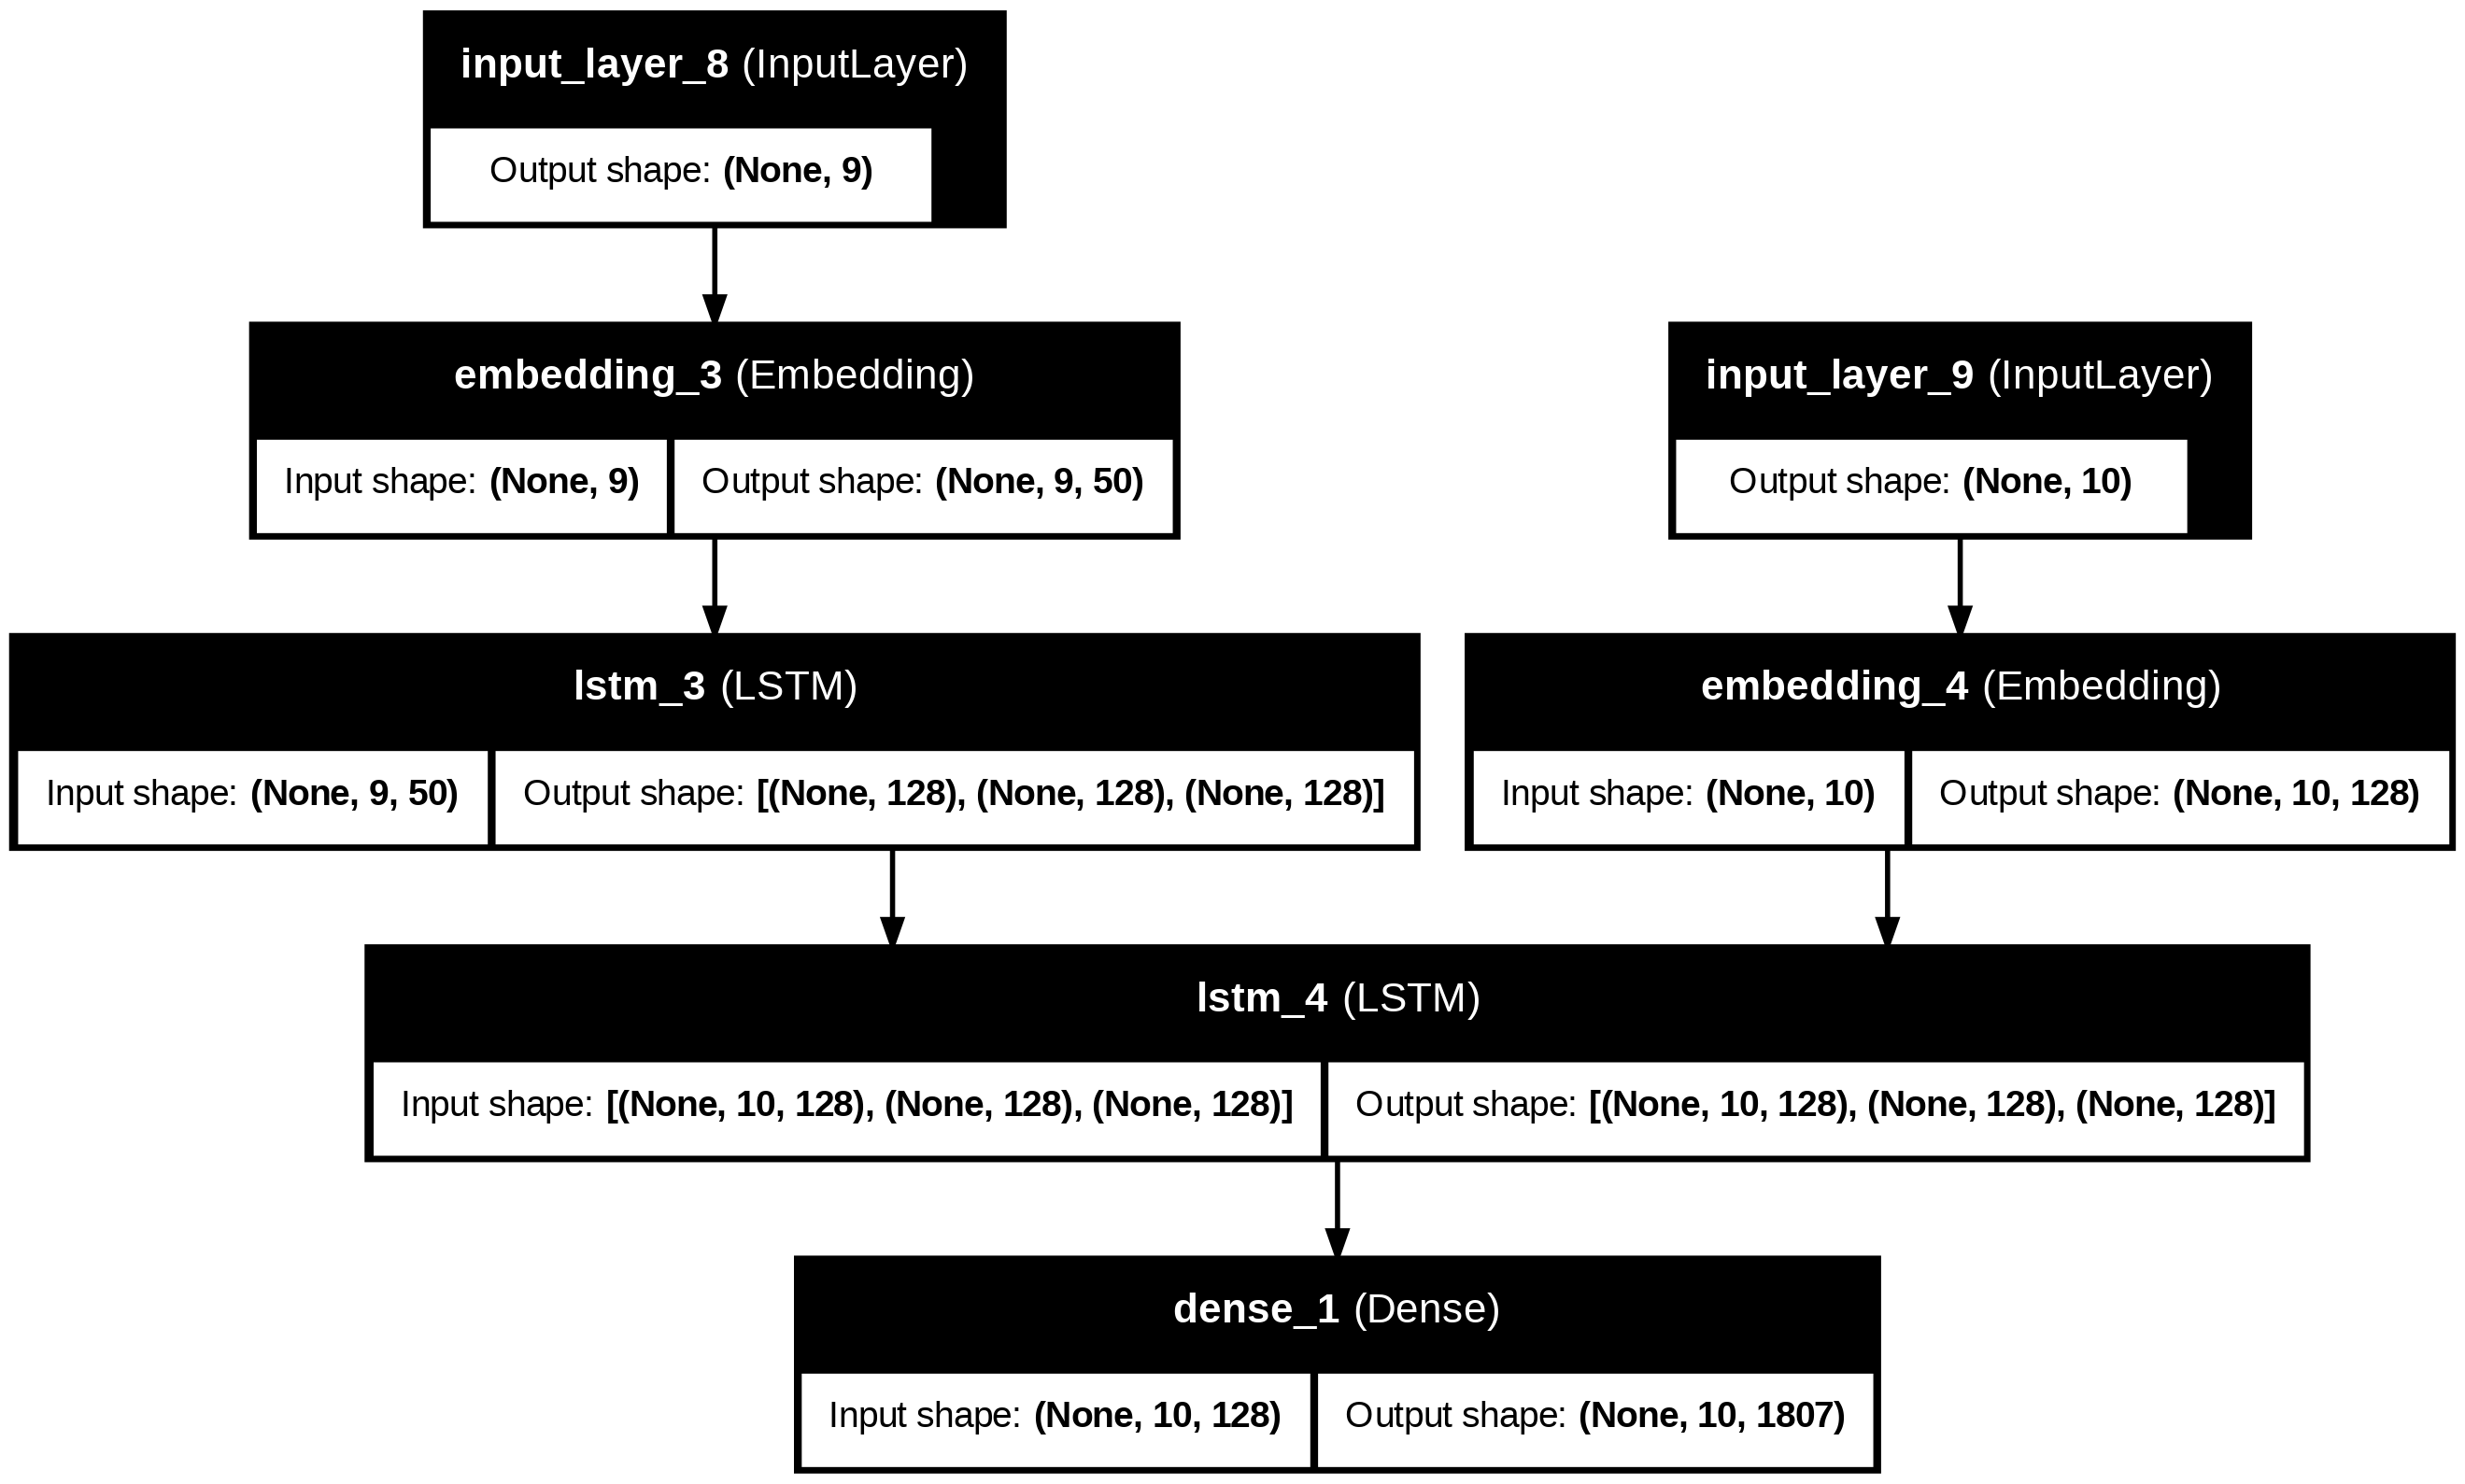

In [28]:
#-----------------
# Visualizando la estructura del modelo
#-----------------
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Para trabajar directamente con los estados del codificador, se crea en la siguiente celda un modelo separado para el codificador. Este modelo codificador se puede usar para generar los estados ocultos de una secuencia de entrada, los cuales luego se pueden usar como entrada inicial para el decodificador en un paso posterior.

Este modelo procesa la secuencia de entrada y genera dos estados (`state_h` y `state_c`) que son utilizados por el decodificador. La visualización (plot_model) ayuda a observar la arquitectura de este modelo:

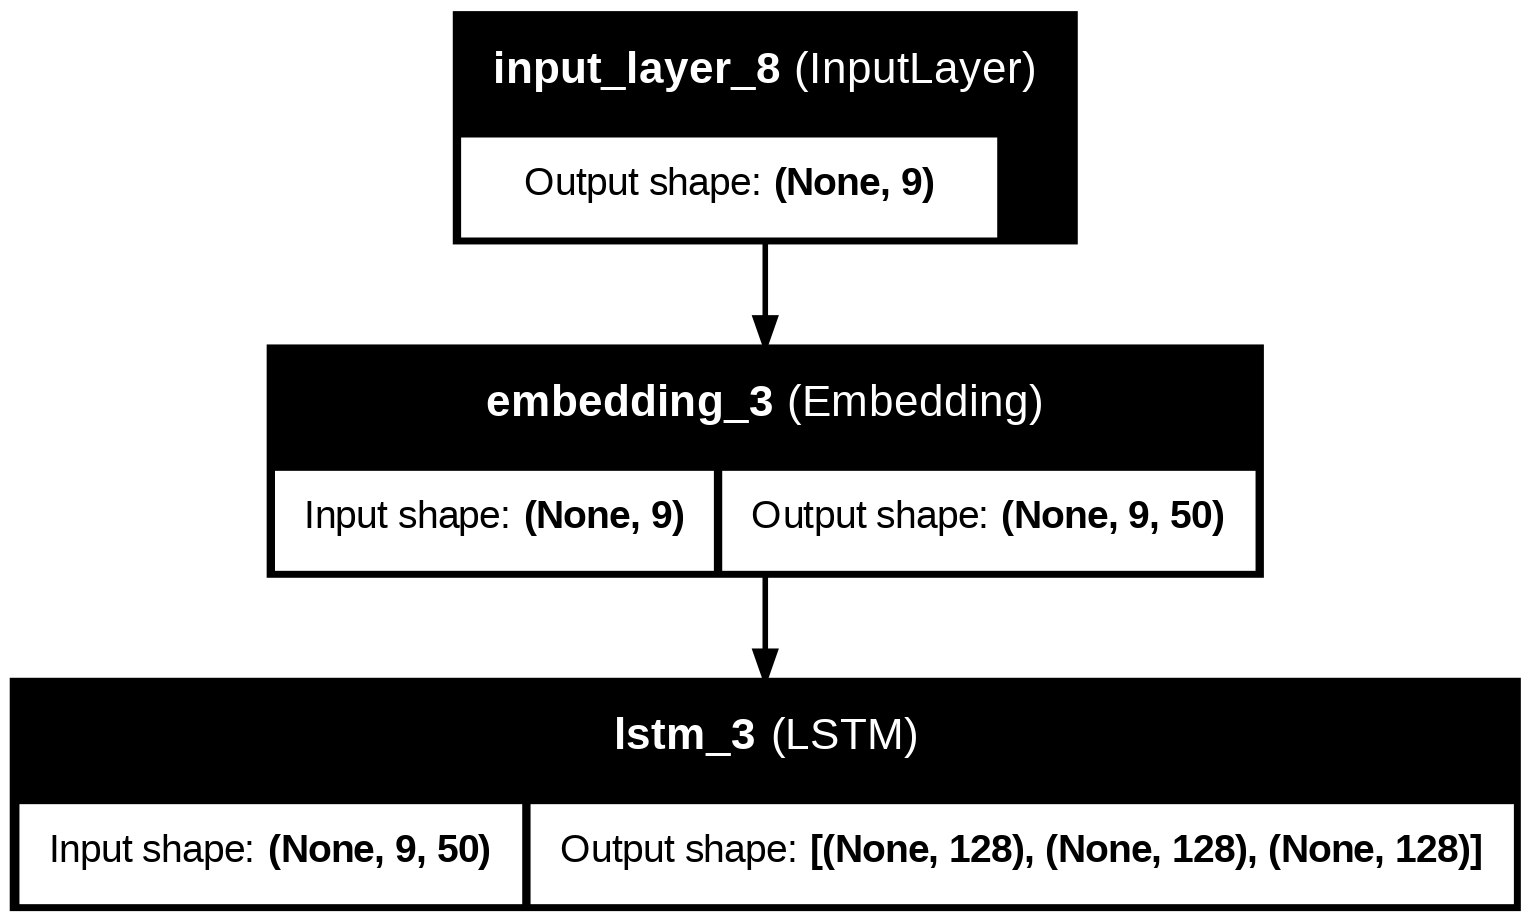

In [29]:
#-----------------
# Modelo para el encoder
#-----------------
encoder_model = Model(encoder_inputs, encoder_states)

#-----------------
# Visualizando la estructura del modelo
#-----------------
plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

Del mismo modo, se define a continuación un modelo de inferencia para el decodificador. El modelo de inferencia se utiliza durante la fase de predicción, donde se generan secuencias de salida palabra por palabra, en lugar de procesar toda la secuencia de salida de una vez como se hace durante el entrenamiento.

Por lo tanto, en cada predicción habrá una sola palabra de entrada al decoder, que es la realimentación de la palabra anterior, por lo que hay que modificar el input shape de la layer de Embedding:

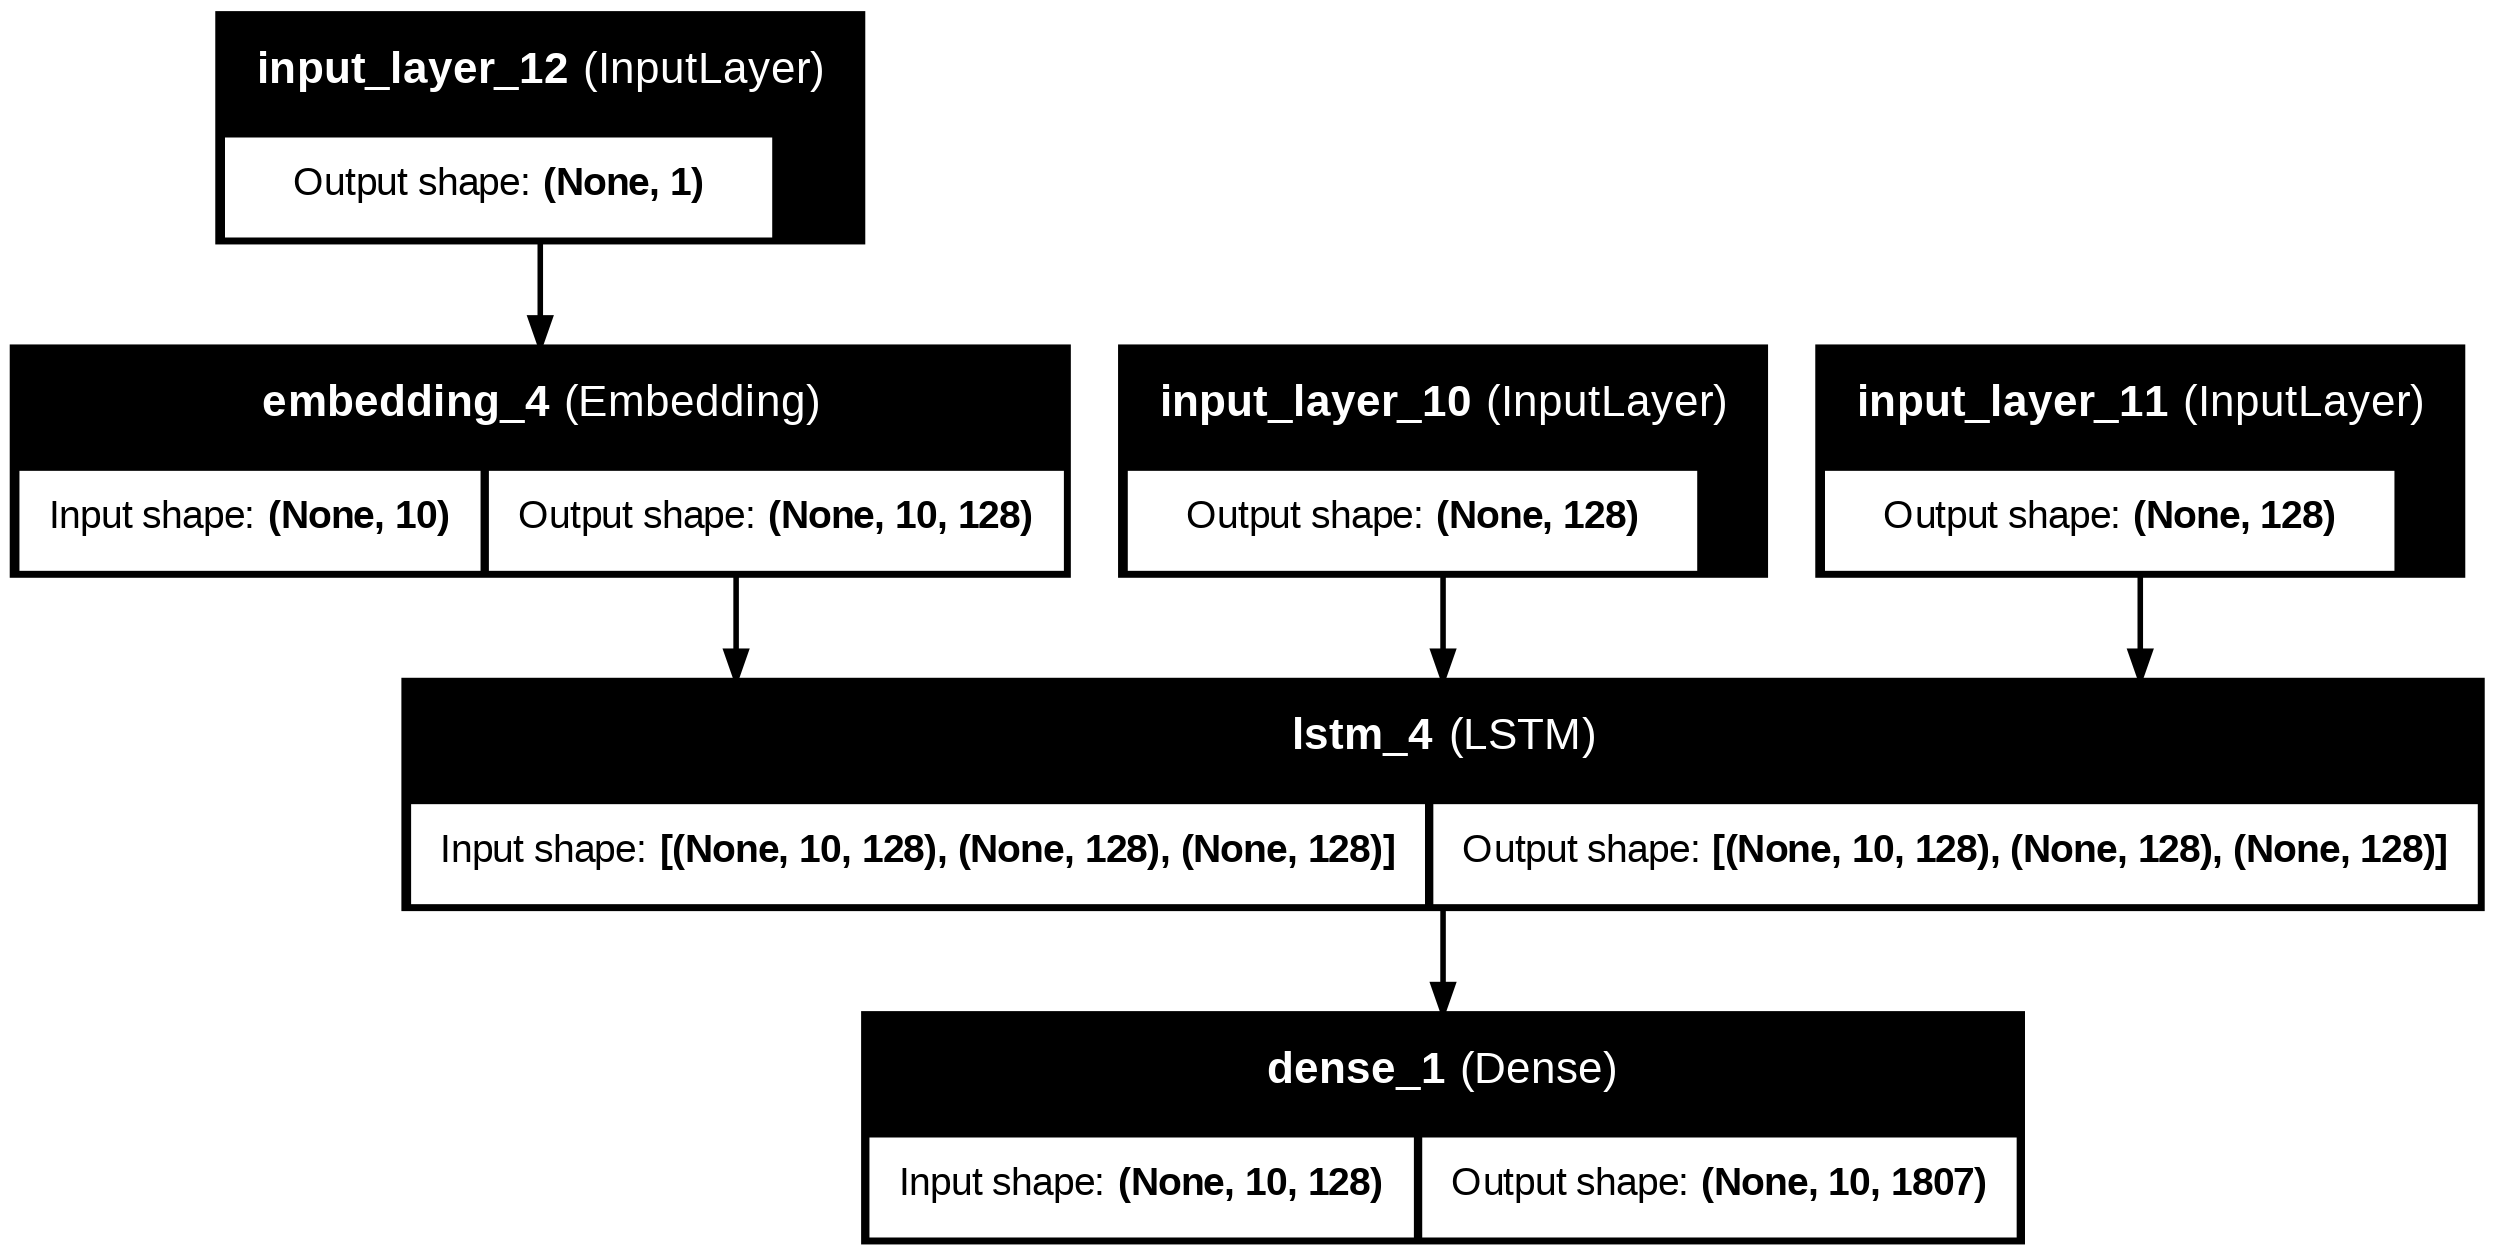

In [30]:
#-----------------
# Definiendo las entradas del estado del decodificador
#-----------------
decoder_state_input_h = Input(shape=(n_units,)) # Estados ocultos
decoder_state_input_c = Input(shape=(n_units,)) # Estados de memoria
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c] # Agrupando los estados para la LSTM

#-----------------
# Entradas del decodificador para una sola palabra
#-----------------
decoder_inputs_single = Input(shape=(1,)) # Input de una sola pálabra
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single) # Embedding de la palabra de entrada

#-----------------
# Decodificando y generando estados de salida
#-----------------
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

#-----------------
# Capa de salida
#-----------------
decoder_outputs = decoder_dense(decoder_outputs)

#-----------------
# Definiendo el modelo de inferencia
#-----------------
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

#-----------------
# Visualizando la estructura del modelo
#-----------------
plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

El modelo se entrena tomando los datos de entrada y las etiquetas (o targets), y ajustando los pesos del modelo para minimizar la función de pérdida a lo largo de 50 épocas:

In [31]:
#-----------------
# Entrenando el modelo
#-----------------
hist = model.fit([encoder_input_sequences, decoder_input_sequences],decoder_targets,epochs=50,validation_split=0.2)

Epoch 1/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.4955 - loss: 4.1972 - val_accuracy: 0.6323 - val_loss: 2.1982
Epoch 2/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6211 - loss: 2.0744 - val_accuracy: 0.6640 - val_loss: 2.0299
Epoch 3/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6793 - loss: 1.8076 - val_accuracy: 0.6896 - val_loss: 1.9006
Epoch 4/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.7059 - loss: 1.6375 - val_accuracy: 0.7007 - val_loss: 1.8195
Epoch 5/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7242 - loss: 1.5221 - val_accuracy: 0.7109 - val_loss: 1.7701
Epoch 6/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7339 - loss: 1.4531 - val_accuracy: 0.7140 - val_loss: 1.7316
Epoch 7/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7434 - loss: 1.3797 - val_accuracy: 0.7171 - val_loss: 1.7072
Epoch 8/50
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7426 - loss: 1.3572 - val_accuracy:

Para visualizar cómo la precisión del modelo cambia durante el entrenamiento en cada época, tanto en los datos de entrenamiento como en los de validación, se genera el siguiente gráfico:

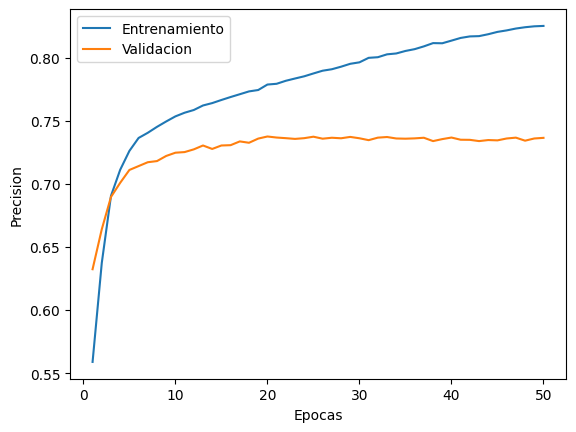

In [32]:
#-----------------
# Rango de épocas
#-----------------
epoch_count = range(1, len(hist.history['accuracy']) + 1)

#-----------------
# Gráfico de precisión en el entrenamiento
#-----------------
sns.lineplot(x=epoch_count, y=hist.history['accuracy'], label='Entrenamiento')

#-----------------
# Gráfico de precisión en la validación
#-----------------
sns.lineplot(x=epoch_count, y=hist.history['val_accuracy'], label='Validacion')

#-----------------
# Mostrando el gráfico
#-----------------
plt.xlabel('Epocas')
plt.ylabel('Precision')
plt.show()

Las curvas de precisión muestran una tendencia ascendente continua a lo largo de las épocas, lo que es indicativo de que el modelo está aprendiendo y generalizando bien a los datos no vistos.

Sin embargo, a partir de un cierto punto (alrededor de la época 10), la precisión en la validación deja de mejorar significativamente y comienza a estabilizarse e incluso muestra pequeñas fluctuaciones alrededor del 70-72%. Esto sugiere que el modelo podría estar comenzando a sobreajustarse a los datos de entrenamiento.

Esto podría mejorar implementando una técnica de parada temprana para detener el entrenamiento cuando la precisión de validación deje de mejorar o ajustando los hiperparámetros del modelo.

## **5. Inferencia**

Ya con el modelo entrenado, se prueba su funcionamiento realizando inferencias de los modelos de encoder y decoder por separado.

Para ello se implementa un proceso iterativo para generar una secuencia de salida palabra por palabra. Comienza con el token <sos> y sigue generando palabras hasta que se alcanza el token <eos> o se alcanza la longitud máxima permitida (max_out_len).

Durante cada paso de la generación, el decodificador utiliza tanto la secuencia generada previamente como los estados internos de la LSTM para predecir la siguiente palabra en la secuencia de salida.


In [34]:
#-----------------
# Construcción de los conversores de índices a palabras:
#-----------------
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

#-----------------
# Función para responder preguntas
#-----------------
def answer_question(input_seq):
    #-----------------
    # Transformando la sequencia de entrada a los estados "h" y "c" de la LSTM
    # para enviar la primera vez al decoder
    #-----------------
    states_value = encoder_model.predict(input_seq)

    #-----------------
    # Inicializando la secuencia de entrada al decoder como "<sos>"
    #-----------------
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['sos']

    #-----------------
    # Obteniendo el índice que finaliza la inferencia
    #-----------------
    eos = word2idx_outputs['eos']

    output_sentence = []
    for _ in range(max_out_len):
        #-----------------
        # Predicción del próximo elemento
        #-----------------
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        #-----------------
        # Si es "end of sentece <eos>" se acaba
        #-----------------
        if eos == idx:
            break

        #-----------------
        # Transformar idx a palabra
        #-----------------
        word = ''
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        #-----------------
        # Actualizando los estados dada la última predicción
        #-----------------
        states_value = [h, c]

        #-----------------
        # Actualizando la secuencia de entrada con la salida (re-alimentación)
        #-----------------
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

La primera prueba consiste en seleccionar aleatoriamente una secuencia de entrada desde los datos de entrenamiento y utilizar el modelo entrenado para generar una respuesta. Luego se imprime tanto la secuencia de entrada original como la respuesta generada:

In [44]:
#-----------------
# Seleccionando una secuencia de entrada aleatoria
#-----------------
i = np.random.choice(len(input_sentences))

#-----------------
# Transformando la secuencia de entrada
#-----------------
input_seq = encoder_input_sequences[i:i+1]

#-----------------
# Obteniendo la respuesta
#-----------------
answer = answer_question(input_seq)

#-----------------
# Mostrando los resultados
#-----------------
print('-')
print('Input:', input_sentences[i])
print('Response:', answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
-
Input: that is a cool car what kind 
Response: i like to go to the beach


Aunque el modelo logra responder coherentemente a cierts preguntas directas como *how are you?* o *what do you do for a living?*, existen otras secuencias que no necesariamente son preguntas y que generan confusión en el modelo, llevándolo a dar respuestas sin sentido o a manifestar que no entiende el input.

También es posible realizar preguntas directamente al modelo como se muestra a continuación:

In [47]:
#-----------------
# Pregunta del usuario en ingles
#-----------------
input_test = input("Ask a question: ")

#-----------------
# Transformando la pregunta a una secuencia de entrada
#-----------------
integer_seq_test = tokenizer_inputs.texts_to_sequences([input_test])[0]

#-----------------
# Padding de la secuencia de entrada
#-----------------
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)

#-----------------
# Obteniendo la respuesta
#-----------------
answer = answer_question(encoder_sequence_test)

#-----------------
# Mostrando los resultados
#-----------------
print('-')
print('Answer:', answer)
print('-')

print("\nRepresentacion en vector de tokens de ids:", integer_seq_test)
print("\nPadding del vector:", encoder_sequence_test)

Ask a question: what's your name?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
-
Answer: i love to read
-

Representacion en vector de tokens de ids: [21, 51]

Padding del vector: [[ 0  0  0  0  0  0  0 21 51]]
